In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys
import numpy as np
import json
from collections import defaultdict, Counter
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel, SelectKBest
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import roc_auc_score


C:\Users\lclai\AppData\Local\Temp\ipykernel_16776\3644271748.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## DESCRIPTIVE STADISTICS AND DATA VISUALIZATION

In [3]:
clindata = pd.read_csv('C:/Users/lclai/Desktop/VHIO/codisdef/codisdef/clinical_biological_db_20230905.csv')
clindata.columns

Index(['Unnamed: 0', 'patient_id', 'DB', 'sex', 'DOB', 'EOT_reason',
       'primary_tlocation', 'BL_CT_date', 'first_CT_date', 'BR_CT_date',
       'PD_CT_date', 'RECIST', 'trial_start_date', 'PFS_months', 'OS_months',
       'last_FU', 'cb_5mo', 'cb_4mo', 'status_at_last_FU', 'n_lesions',
       'n_loc_lesions', 'age', 'cb_PFS', 'treatment', 'total_seg_vol',
       'PFS_censored', 'liver_met', 'baseline_lymphos', 'baseline_neutroph',
       'baseline_leucocytes', 'baseline_platelets', 'baseline_albumin',
       'baseline_LDH', 'baseline_num_met_organs', 'baseline_ECOG'],
      dtype='object')

In [4]:
cols = ['patient_id','sex','primary_tlocation','n_lesions','age','treatment','total_seg_vol',
        'liver_met','baseline_lymphos', 'baseline_neutroph',
       'baseline_leucocytes', 'baseline_platelets', 'baseline_albumin',
       'baseline_LDH', 'baseline_num_met_organs', 'baseline_ECOG', 'cb_4mo']
clindata = clindata[cols]
clindata

,patient_id,sex,primary_tlocation,n_lesions,age,treatment,total_seg_vol,liver_met,baseline_lymphos,baseline_neutroph,baseline_leucocytes,baseline_platelets,baseline_albumin,baseline_LDH,baseline_num_met_organs,baseline_ECOG,cb_4mo
0,14947437,female,ovary,10,72,combo immuno,47417.902780,0,2.0,3.4,6.29,302.0,3.1,418.0,1.0,1.0,1
1,10049517,male,esophagus,3,61,combo immuno,54198.513890,0,3.0,5.0,9.00,189.0,4.1,377.0,2.0,0.0,1
2,10262640,male,kidney,4,50,combo immuno,40001.152770,1,1.6,4.6,7.12,224.0,3.8,323.0,3.0,1.0,0
3,10599018,male,head_and_neck,4,54,combo immuno,8589.875000,0,2.2,3.2,6.10,217.0,4.6,446.0,3.0,0.0,1
4,10897916,female,skin,3,58,combo immuno,27891.166660,0,2.0,2.4,4.93,298.0,4.1,283.0,1.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,18895067,male,liver,1,37,monotherapy,238646.916700,0,1.0,3.6,5.31,256.0,4.3,415.0,2.0,0.0,1
182,19309727,female,cervix,1,45,monotherapy,4228.861111,0,1.0,2.8,4.21,171.0,3.8,318.0,2.0,1.0,1
183,260626,female,pleura,1,65,monotherapy,1860.968750,0,1.1,4.0,6.12,455.0,3.2,443.0,3.0,0.0,1
184,412386,female,cervix,2,67,monotherapy,13703.305550,0,1.0,4.4,6.04,275.0,3.9,NaN,2.0,0.0,1


In [16]:
id = 13075225
clindata = clindata[clindata['patient_id']!= id]

In [8]:
rad = pd.read_csv("C:/Users/lclai/Desktop/VHIO/codisdef/codisdef/total_df.csv")
rad.shape
rad

,Unnamed: 0,Patient,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,...,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength,GT
0,0,108278_other_1,0.661330,0.588529,34.646732,58.409169,65.464166,67.314754,46.362644,68.272130,...,0.014790,6.015306,0.019802,831064.770000,47.491996,0.000171,50.217603,0.007755,0.017041,1
1,1,113834_node_1,0.854109,0.699889,12.901870,18.434164,22.825424,22.360680,18.384776,25.000000,...,0.066422,4.755866,0.017928,31196.128400,3.548068,0.004313,15.592173,0.017162,0.138387,0
2,2,113834_node_2,0.776220,0.663190,20.681892,31.185454,33.241540,32.015621,35.000000,36.959437,...,0.074522,5.245353,0.011312,474931.741000,20.358177,0.001030,8.356531,0.003534,0.034071,0
3,3,120455_lung_1,0.807908,0.655298,18.655433,28.503049,29.095358,31.625062,31.857480,34.111805,...,0.009717,6.216212,0.082081,16580.772130,0.954961,0.001745,196.308490,0.020993,0.824026,1
4,4,182471_node_1,0.761792,0.717238,14.326037,19.973907,23.853721,22.360680,18.601075,25.139610,...,0.115421,4.653496,0.011785,78688.243080,8.008769,0.003346,7.177009,0.011026,0.067110,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1040,1040,19460793_node_1,0.537780,0.478021,24.644979,44.795218,47.653120,47.419656,33.000000,50.849418,...,0.005908,6.037018,0.082730,277968.722700,4.047678,0.003386,254.273010,0.013197,2.375395,0
1041,1041,19862407_lung_1,0.554793,0.517571,17.328681,33.480751,23.853721,37.696154,35.355339,38.026307,...,0.017330,5.995559,0.104682,7905.803961,1.077717,0.002055,141.927865,0.035061,0.495863,0
1042,1042,19862407_node_1,0.889266,0.718473,33.425241,46.522640,53.000000,51.478151,53.758720,55.045436,...,0.006622,6.365957,0.026804,400982.243300,5.136231,0.000241,162.005099,0.003775,0.220835,0
1043,1043,19862407_other_3,0.712177,0.590951,16.998195,28.764114,33.105891,32.310989,24.083189,33.660065,...,0.038513,5.669417,0.017098,126842.569200,10.076349,0.001370,15.858011,0.011592,0.049637,0


In [17]:
clindata.isnull().sum()

patient_id                  0
sex                         0
primary_tlocation           0
n_lesions                   0
age                         0
treatment                   0
total_seg_vol               0
liver_met                   0
baseline_lymphos            0
baseline_neutroph           0
baseline_leucocytes         0
baseline_platelets          0
baseline_albumin            0
baseline_LDH               24
baseline_num_met_organs     0
baseline_ECOG               3
cb_4mo                      0
dtype: int64

In [28]:
clindata.columns

Index(['patient_id', 'sex', 'primary_tlocation', 'n_lesions', 'age',
       'treatment', 'total_seg_vol', 'liver_met', 'baseline_lymphos',
       'baseline_neutroph', 'baseline_leucocytes', 'baseline_platelets',
       'baseline_albumin', 'baseline_LDH', 'baseline_num_met_organs',
       'baseline_ECOG', 'cb_4mo'],
      dtype='object')

In [30]:
nom = 'baseline_lymphos'
mean = np.mean(clindata[nom])
print(mean)
std_dev = np.std(clindata[nom])
print(np.std(clindata[nom]))
print(np.min(clindata[nom]))
print(np.max(clindata[nom]))

1.4603783783783781
0.6807089845849456
0.4
5.0


In [7]:
clindata.columns

Index(['patient_id', 'sex', 'primary_tlocation', 'n_lesions', 'age',
       'treatment', 'total_seg_vol', 'liver_met', 'baseline_lymphos',
       'baseline_neutroph', 'baseline_leucocytes', 'baseline_platelets',
       'baseline_albumin', 'baseline_LDH', 'baseline_num_met_organs',
       'baseline_ECOG', 'cb_4mo'],
      dtype='object')

In [8]:
mean = np.mean(clindata['n_lesions'])
print(mean)
std_dev = np.std(clindata['n_lesions'])
print(np.std(clindata['n_lesions']))
print(np.min(clindata['n_lesions']))
print(np.max(clindata['n_lesions']))
upper_bound = mean + 1.96 * (std_dev / np.sqrt(len(clindata['n_lesions'])))
lower_bound = mean - 1.96 * (std_dev / np.sqrt(len(clindata['n_lesions'])))
print(upper_bound)
print(lower_bound)

4.478494623655914
4.687213204700122
1
30
5.1521135917359935
3.8048756555758345


In [24]:
#Counting
print("Number of unique patients: ", clindata['patient_id'].nunique())
print("Sex:", clindata['sex'].value_counts())
#print("tumor locations:", clindata['primary_tlocation'].value_counts())
print("Response:", clindata['cb_4mo'].value_counts())
#print("Treatment:", clindata['treatment'].value_counts())
print("Treatment:", clindata['cb_4mo'].value_counts())
print("Treatment:", clindata['baseline_ECOG'].value_counts())
print("Treatment:", clindata['liver_met'].value_counts())

Number of unique patients:  185
Sex: sex
male      114
female     71
Name: count, dtype: int64
Response: cb_4mo
0    102
1     83
Name: count, dtype: int64
Treatment: cb_4mo
0    102
1     83
Name: count, dtype: int64
Treatment: baseline_ECOG
1.0    111
0.0     67
2.0      4
Name: count, dtype: int64
Treatment: liver_met
0    125
1     60
Name: count, dtype: int64


In [19]:
print("Treatment:", clindata['treatment'].value_counts())

Treatment: treatment
monotherapy      110
combo immuno      73
combo immuno       2
Name: count, dtype: int64


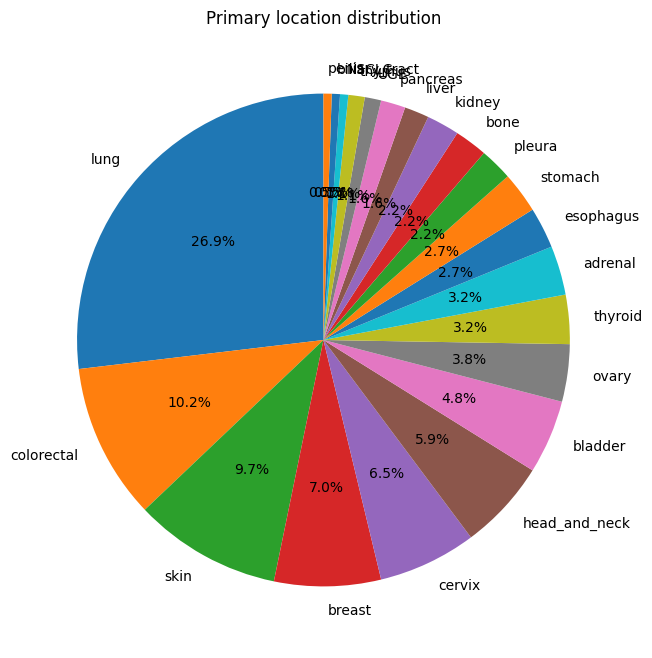

In [11]:
loc = clindata['primary_tlocation'].value_counts()
loc.plot(kind='pie', autopct='%1.1f%%', startangle=90, figsize=(10, 8))
plt.title('Primary location distribution')
plt.ylabel('')
plt.show()

## PREPROCESSING

In [12]:
clindata.columns

Index(['patient_id', 'sex', 'primary_tlocation', 'n_lesions', 'age',
       'treatment', 'total_seg_vol', 'liver_met', 'baseline_lymphos',
       'baseline_neutroph', 'baseline_leucocytes', 'baseline_platelets',
       'baseline_albumin', 'baseline_LDH', 'baseline_num_met_organs',
       'baseline_ECOG', 'cb_4mo'],
      dtype='object')

In [13]:
nas = clindata.isna().sum()
print(nas) #we are dropping the LDH column

patient_id                  0
sex                         0
primary_tlocation           0
n_lesions                   0
age                         0
treatment                   0
total_seg_vol               0
liver_met                   0
baseline_lymphos            1
baseline_neutroph           1
baseline_leucocytes         1
baseline_platelets          1
baseline_albumin            1
baseline_LDH               25
baseline_num_met_organs     1
baseline_ECOG               4
cb_4mo                      0
dtype: int64


In [14]:
#drop column
#clindata = clindata.drop(columns='baseline_LDH', axis=1)
#knn for the remaining missing values
from sklearn.impute import KNNImputer
# Selecting the columns for imputation
columns_for_imputation = [
    "baseline_lymphos", "baseline_neutroph", "baseline_leucocytes",
    "baseline_platelets", "baseline_albumin",
    "baseline_num_met_organs", "baseline_ECOG"
]
data_for_imputation = clindata[columns_for_imputation]
# Using KNN imputer with n_neighbors=5
knn_imputer = KNNImputer(n_neighbors=5)
imputed_data = knn_imputer.fit_transform(data_for_imputation)
# Creating a DataFrame for the imputed data
imputed_data_df = pd.DataFrame(imputed_data, columns=columns_for_imputation)
for column in columns_for_imputation:
    clindata[column] = imputed_data_df[column]

In [15]:
y = clindata['cb_4mo']
patients = clindata[['patient_id']]
toscale = clindata[['n_lesions', 'age','total_seg_vol', 'liver_met', 'baseline_lymphos',
       'baseline_neutroph', 'baseline_leucocytes', 'baseline_platelets',
       'baseline_albumin', 'baseline_num_met_organs',
       'baseline_ECOG']]
binary = clindata[['sex','treatment',]]
categorical = clindata[['primary_tlocation']]

In [16]:
#scaling
scaler = StandardScaler()
scaled = scaler.fit_transform(toscale)
scaled = pd.DataFrame(scaled, columns=toscale.columns)

#encoding
le = LabelEncoder()
binary['sex'] = le.fit_transform(binary['sex']) # 1 es male i 0 es female
binary['treatment'] = binary['treatment'].str.strip()
binary['treatment'] = le.fit_transform(binary['treatment']) # 0 combo 1 monotherapy


#threshold a 10
primarytumor = ['lung','colorectal','skin','breast','cervix','head_and_neck']
for i in range(len(categorical)):
    if categorical.loc[i,'primary_tlocation'] not in primarytumor:
        categorical.loc[i,'primary_tlocation'] = 'other'

C:\Users\lclai\AppData\Local\Temp\ipykernel_3708\1123949147.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  binary['sex'] = le.fit_transform(binary['sex']) # 1 es male i 0 es female
C:\Users\lclai\AppData\Local\Temp\ipykernel_3708\1123949147.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  binary['treatment'] = binary['treatment'].str.strip()
C:\Users\lclai\AppData\Local\Temp\ipykernel_3708\1123949147.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

In [17]:
X= pd.concat([scaled, binary, categorical], axis=1)

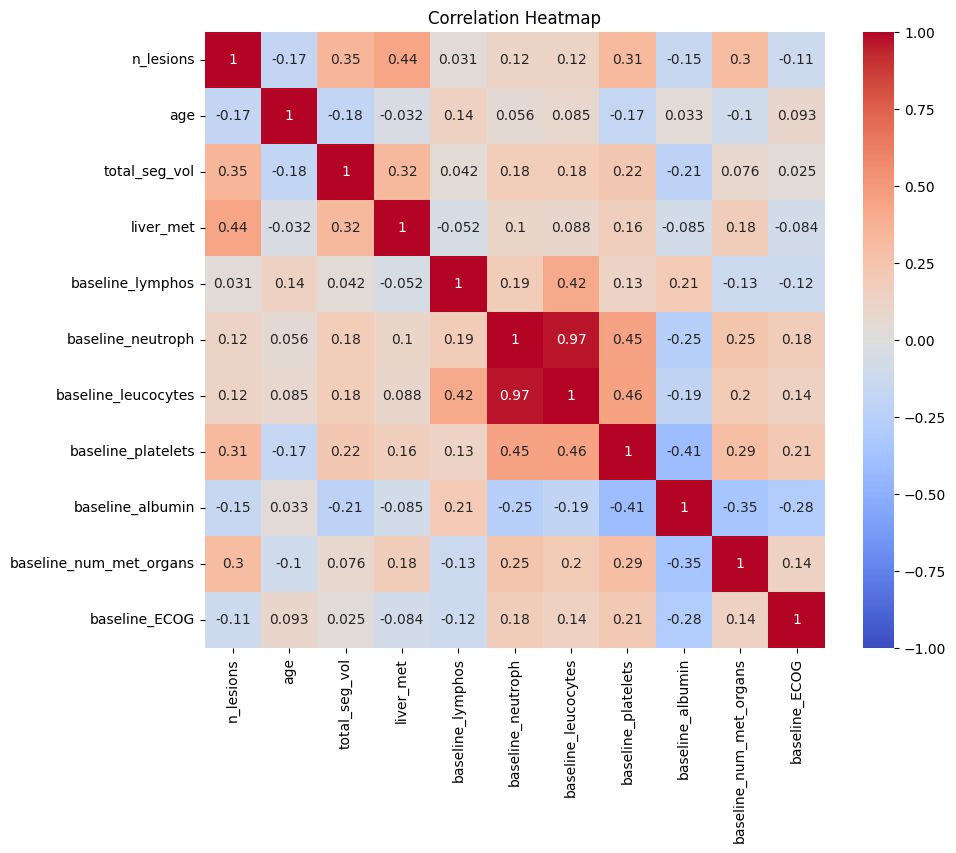

In [18]:
dataheat = X[['n_lesions', 'age', 'total_seg_vol', 'liver_met', 'baseline_lymphos',
       'baseline_neutroph', 'baseline_leucocytes', 'baseline_platelets',
       'baseline_albumin', 'baseline_num_met_organs',
       'baseline_ECOG']]

correlation_matrix = dataheat.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

In [19]:
#one hot encoding
#dummies = pd.get_dummies(X['primary_tlocation'], prefix='encod')
#dummies = dummies.astype(int)
#Xdef = pd.concat([X.drop('primary_tlocation', axis=1), dummies], axis=1)

In [20]:
# one hot encoding modification to -0.5 and 0.5
dummies = pd.get_dummies(X['primary_tlocation'], prefix='encod')
dummies = dummies - 0.5
Xdef = pd.concat([X.drop('primary_tlocation', axis=1), dummies], axis=1)

In [21]:
#saving a csv with the cleaned clinical variables
cleandata = pd.concat([patients,Xdef,y], axis = 1)
cleandata.to_csv("cleanclinicalKNN.csv")

In [22]:
#ML
def lasso_fselection(X_train, y_train, inner_cv):
    pipe = Pipeline([
        ('selector', SelectFromModel(LogisticRegression(penalty='l1', solver='liblinear', max_iter=500, random_state=123))),
        ('classifier', LogisticRegression(penalty='elasticnet', solver='saga', max_iter=500))
    ])
    param_distributions = {
        'selector__estimator__C': [0.01, 0.1, 1, 10],  
        'classifier__l1_ratio': [0.3,0.5,1]
    }
    
    rs = RandomizedSearchCV(pipe, param_distributions=param_distributions, n_iter=30, scoring='roc_auc', cv=inner_cv)
    rs.fit(X_train, y_train.values.ravel())
    selected_features = X_train.columns[rs.best_estimator_.named_steps['selector'].get_support()]
    results = {
        'selected_features': selected_features,
        'estimator_C': rs.best_params_['selector__estimator__C'],
        'l1_ratio': rs.best_params_['classifier__l1_ratio']
    }
    return results
    

In [23]:
def flexible_nested_cv_optimized(X, y, outer_cv, inner_cv):

    inner_results = []
    outer_results = []
    
    outer_fold_counter = 1  

    for train_idx_outer, val_idx_outer in outer_cv.split(X, y):
        feature_counts = defaultdict(int)
        C_counts = defaultdict(int)
        l1_ratio_counts = defaultdict(int)
        
        inner_fold_counter = 1  

        for train_idx_inner, val_idx_inner in inner_cv.split(X.iloc[train_idx_outer], y.iloc[train_idx_outer]):
            X_train_inner, y_train_inner = X.iloc[train_idx_inner], y.iloc[train_idx_inner]
            X_val_inner, y_val_inner = X.iloc[val_idx_inner], y.iloc[val_idx_inner]
            
            results_inner = lasso_fselection(X_train_inner, y_train_inner, inner_cv)
            final_features = results_inner['selected_features']
         
            for feature in final_features:
                feature_counts[feature] += 1
            C_counts[results_inner['estimator_C']] += 1
            l1_ratio_counts[results_inner['l1_ratio']] += 1
            
            inner_model = LogisticRegression(penalty='elasticnet', solver='saga', C=results_inner['estimator_C'], 
                                             l1_ratio=results_inner['l1_ratio'], max_iter=500, random_state=123)
            
            inner_model.fit(X_train_inner[final_features], y_train_inner.values.ravel())
            y_pred_inner = inner_model.predict_proba(X_val_inner[final_features])[:, 1]
            auc_inner = roc_auc_score(y_val_inner, y_pred_inner)
            
            inner_results.append({
                'Fold': 'outer_' + str(outer_fold_counter)+'_inner_' + str(inner_fold_counter),
                'Features': final_features, 
                'C': results_inner['estimator_C'], 
                'l1_ratio': results_inner['l1_ratio'],
                'AUC': auc_inner
            })
        
            inner_fold_counter += 1  

        most_common_features = [feature for feature, _ in Counter(feature_counts).most_common(5)]  
        most_common_C = Counter(C_counts).most_common(1)[0][0]
        most_common_l1_ratio = Counter(l1_ratio_counts).most_common(1)[0][0]
        
        X_train_outer, y_train_outer = X.iloc[train_idx_outer], y.iloc[train_idx_outer]
        X_val_outer, y_val_outer = X.iloc[val_idx_outer], y.iloc[val_idx_outer]
        
        final_model = LogisticRegression(penalty='elasticnet', solver='saga', C=most_common_C, l1_ratio=most_common_l1_ratio, max_iter=500, random_state=123)
        final_model.fit(X_train_outer[most_common_features], y_train_outer.values.ravel())
        y_pred_outer = final_model.predict_proba(X_val_outer[most_common_features])[:, 1]
        auc_outer = roc_auc_score(y_val_outer, y_pred_outer)
        
        outer_results.append({
            'Fold': 'outer_fold_' + str(outer_fold_counter),  
            'Features': most_common_features,
            'C': most_common_C,
            'l1_ratio': most_common_l1_ratio,
            'AUC': auc_outer
        })
        
        outer_fold_counter += 1 

    return pd.DataFrame(inner_results), pd.DataFrame(outer_results)

In [24]:
def final_model(X, y, outer_results_df, odir):
    all_features = [feat for sublist in outer_results_df['Features'].tolist() for feat in sublist]
    most_common_features = [feature for feature, _ in Counter(all_features).most_common(5)]
    
    most_common_C = Counter(outer_results_df['C']).most_common(1)[0][0]
    most_common_l1_ratio = Counter(outer_results_df['l1_ratio']).most_common(1)[0][0]
    
    final_model = LogisticRegression(penalty='elasticnet', solver='saga', C=most_common_C, 
                                     l1_ratio=most_common_l1_ratio, max_iter=500)
    final_model.fit(X[most_common_features], y.values.ravel())
    
    coefficients = final_model.coef_[0]
    intercept = final_model.intercept_[0]
    
    avg_auc = outer_results_df['AUC'].mean()
    print(avg_auc)
    std_auc = outer_results_df['AUC'].std()
    
    results = {
        'Average AUC': avg_auc,
        'Standard Deviation AUC': std_auc,
        'Most Common Hyperparameters': {
            'C': most_common_C,
            'l1_ratio': most_common_l1_ratio
        },
        'Model Coefficients': dict(zip(most_common_features, coefficients)),
        'Model Intercept': intercept,
        'Selected Features': most_common_features
    }
    print(results)
    final_model_path = os.path.join(odir, name+".json")
    with open(final_model_path, 'w') as f:
       json.dump(results, f, indent=4)

    return final_model_path

In [26]:
odir = 'C:/Users/lclai/Desktop/codisdef/codisdef/aggregationmethods/186'
name = 'clinicalonlyKNN-0.5'
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
inner_results_df, outer_results_df=flexible_nested_cv_optimized(Xdef, y, outer_cv, inner_cv)
final_results = final_model(Xdef, y, outer_results_df, odir)

c:\Users\lclai\miniconda3\envs\envlaia\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 12 is smaller than n_iter=30. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\lclai\miniconda3\envs\envlaia\Lib\site-packages\sklearn\feature_selection\_base.py:121: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
c:\Users\lclai\miniconda3\envs\envlaia\Lib\site-packages\sklearn\feature_selection\_base.py:121: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
c:\Users\lclai\miniconda3\envs\envlaia\Lib\site-packages\sklearn\feature_selection\_base.py:121: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
c:\Users\lclai\miniconda3\envs\envlaia\Lib\site-packages\sklearn\feature_selection\_base.py:121:

0.6993417366946779
{'Average AUC': 0.6993417366946779, 'Standard Deviation AUC': 0.052756930441798085, 'Most Common Hyperparameters': {'C': 0.1, 'l1_ratio': 0.3}, 'Model Coefficients': {'n_lesions': -0.4631870306958525, 'liver_met': -0.23183853277295888, 'baseline_lymphos': 0.22484537279597847, 'baseline_num_met_organs': -0.20091391300205586, 'age': 0.12842790886886493}, 'Model Intercept': -0.2456142134589835, 'Selected Features': ['n_lesions', 'liver_met', 'baseline_lymphos', 'baseline_num_met_organs', 'age']}


c:\Users\lclai\miniconda3\envs\envlaia\Lib\site-packages\sklearn\feature_selection\_base.py:121: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
c:\Users\lclai\miniconda3\envs\envlaia\Lib\site-packages\sklearn\feature_selection\_base.py:121: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
c:\Users\lclai\miniconda3\envs\envlaia\Lib\site-packages\sklearn\feature_selection\_base.py:121: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
c:\Users\lclai\miniconda3\envs\envlaia\Lib\site-packages\sklearn\feature_selection\_base.py:121: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
c:\Users\lclai\miniconda3\envs\envlaia\Lib\site-packages\sklearn\feature_selection\_base.py:121: UserWarning: No features were selec